<a href="https://colab.research.google.com/github/ZhanyangZhuSD/UCSD_ML/blob/main/HomeCreditDefaultRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

[Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search/notebook)

With the necessary background out of the way, let's get started. For this notebook, we will work with a subset of the data consisting of 10000 rows. Hyperparameter tuning is extremely computationally expensive and working with the full dataset in a Kaggle Kernel would not be feasible for more than a few search iterations. However, the same ideas that we will implement here can be applied to the full dataset and while this notebook is specifically aimed at the GBM, the methods can be applied for any machine learning model.

To "test" the tuning results, we will save some of the training data, 6000 rows, as a separate testing set. When we do hyperparameter tuning, it's crucial to not tune the hyperparameters on the testing data. We can only use the testing data a single time when we evaluate the final model that has been tuned on the validation data. To actually test our methods from this notebook, we would need to train the best model on all of the training data, make predictions on the actual testing data, and then submit our answers to the competition.

In [5]:
from google.colab import files
from os.path import exists

selectedFile = 'application_train.csv.zip'
file_not_exists = not exists(selectedFile)
if file_not_exists:
  uploaded = files.upload()
file_not_exists = not exists(selectedFile)
if file_not_exists: 
  print("Upload this file: ", selectedFile)
else:
  print("File is ready to read: ", selectedFile)

Saving application_train.csv.zip to application_train.csv.zip
File is ready to read:  application_train.csv.zip


In [6]:
features = pd.read_csv('application_train.csv.zip')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

In [7]:
features.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
245895,2,207000.0,465457.5,52641.0,418500.0,0.009630,-13297,-762,-637.0,-4307,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
98194,0,247500.0,1281712.5,48946.5,1179000.0,0.006852,-14778,-1141,-1610.0,-4546,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
36463,0,202500.0,495000.0,39109.5,495000.0,0.035792,-17907,-639,-2507.0,-1461,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
249923,0,247500.0,254700.0,24939.0,225000.0,0.046220,-19626,-6982,-11167.0,-3158,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
158389,0,112500.0,308133.0,15862.5,234000.0,0.018850,-20327,-1105,-7299.0,-494,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0


In [8]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

The code below carries out both cross validation with 5 folds and early stopping with 100 early stopping rounds.

In [9]:
# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [10]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.70058 with a standard deviation of 0.02819.
The optimal number of boosting rounds (estimators) was 23.


In [11]:
print(cv_results)

{'auc-mean': [0.6428272158043613, 0.6558184167965992, 0.6669743997916001, 0.6712996780435617, 0.6754613466829367, 0.6868799192105205, 0.6884562733692469, 0.690190171905673, 0.6918857334809868, 0.6930918270889311, 0.6940758415623899, 0.6952711094828053, 0.6970703107118916, 0.6998644647529685, 0.6993248741167377, 0.6989451551707433, 0.699567939922585, 0.6977658243958775, 0.698623301781725, 0.6981052137725586, 0.6986588366780728, 0.6998992147524594, 0.700578772037319], 'auc-stdv': [0.023300891793162793, 0.027518423452609044, 0.02750145800743168, 0.02859198596492385, 0.030157610403498864, 0.03266370277854025, 0.03342234227155733, 0.03435780673037538, 0.03163355257305701, 0.03411672092829849, 0.03008682798273077, 0.029052080308636007, 0.029436712157318082, 0.029929619638483135, 0.02923177726869975, 0.030288392138814915, 0.030579247843779873, 0.03030809666555721, 0.030081154652335407, 0.029004713936325532, 0.03094772780673007, 0.029364307447814156, 0.028189318313561054]}


In [38]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

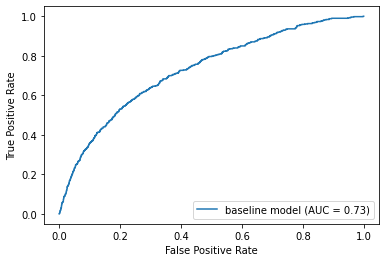

The baseline model scores 0.72832 ROC AUC on the test set.
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 23, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [37]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(test_labels, preds)
baseline_auc = roc_auc_score(test_labels, preds)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=baseline_auc,
                                 estimator_name='baseline model')
display.plot()

plt.show()

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))
print(model.get_params())

This is the baseline score before hyperparameter tuning. The only difference we made from the default model was using early stopping to set the number of estimators (which by default is 100).

In [44]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
#    cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100,
#                                   metrics = 'auc', nfold = N_FOLDS, seed = 42)    
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [45]:
print(default_params)
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'n_estimators': 23}
The cross-validation ROC AUC was 0.70058.


In [46]:
# Create a default model
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [66]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [48]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


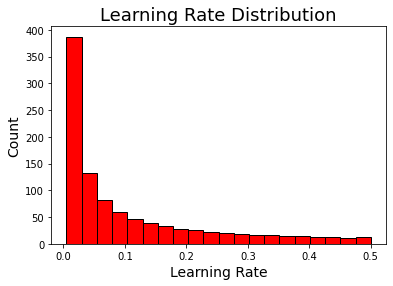

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

In [50]:
a = 0
b = 0

# Check number of values in each category
for x in param_grid['learning_rate']:
    # Check values
    if x >= 0.005 and x < 0.05:
        a += 1
    elif x >= 0.05 and x < 0.5:
        b += 1

print('There are {} values between 0.005 and 0.05'.format(a))
print('There are {} values between 0.05 and 0.5'.format(b))

There are 499 values between 0.005 and 0.05
There are 499 values between 0.05 and 0.5


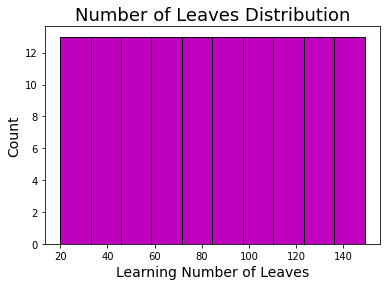

In [51]:
# number of leaves domain
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

In [52]:
# Dataframes for random and grid search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

In [53]:
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 2620800000000000 combinations


In [54]:
print('This would take {:.0f} years to finish.'.format((100 * com) / (60 * 60 * 24 * 365)))

This would take 8310502283 years to finish.


In [55]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [56]:
keys, values = zip(*param_grid.items())
print(keys, values)

('boosting_type', 'num_leaves', 'learning_rate', 'subsample_for_bin', 'min_child_samples', 'reg_alpha', 'reg_lambda', 'colsample_bytree', 'subsample', 'is_unbalance') (['gbdt', 'goss', 'dart'], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], [0.004999999999999999, 0.005023102106734065, 0.005046310954935236, 0.005069627037794076, 0.005093050850779875, 0.005116582891651224, 0.005140223660466548, 0.005163973659594757, 0.005187833393725929, 0.005211803369882005, 0.00523588409

In [57]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.72029

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 818,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}


In [58]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from grid search scores 0.73266 ROC AUC on the test set.


In [60]:
pd.options.display.max_colwidth = 1000
grid_results['params'].values

array([{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'n_estimators': 818},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': False, 'n_estimators': 818},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5050505050505051, 'is_unbalance': True, 'n_estimators': 818},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'co

In [61]:
random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'goss',
 'num_leaves': 88,
 'learning_rate': 0.027778881111994384,
 'subsample_for_bin': 220000,
 'min_child_samples': 175,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 1.0,
 'is_unbalance': False}

In [62]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [67]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}
# param_grid['boosting_type'] = ['gbdt', 'goss'],
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

The best validation score was 0.72325

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9111111111111111,
 'is_unbalance': False,
 'learning_rate': 0.03748390937483438,
 'min_child_samples': 360,
 'n_estimators': 154,
 'num_leaves': 147,
 'reg_alpha': 0.8775510204081632,
 'reg_lambda': 0.16326530612244897,
 'subsample': 0.8686868686868687,
 'subsample_for_bin': 180000}


In [68]:
# Get the best parameters
random_search_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from random search scores 0.73337 ROC AUC on the test set.


In [69]:
random_results['params']

0    {'boosting_type': 'gbdt', 'num_leaves': 147, 'learning_rate': 0.03748390937483438, 'subsample_for_bin': 180000, 'min_child_samples': 360, 'reg_alpha': 0.8775510204081632, 'reg_lambda': 0.16326530612244897, 'colsample_bytree': 0.9111111111111111, 'subsample': 0.8686868686868687, 'is_unbalance': False, 'n_estimators': 154}
1                    {'boosting_type': 'goss', 'num_leaves': 77, 'learning_rate': 0.010747373367189901, 'subsample_for_bin': 240000, 'min_child_samples': 385, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.16326530612244897, 'colsample_bytree': 0.7777777777777778, 'subsample': 1.0, 'is_unbalance': True, 'n_estimators': 93}
2                                 {'boosting_type': 'goss', 'num_leaves': 137, 'learning_rate': 0.009062087736871187, 'subsample_for_bin': 100000, 'min_child_samples': 415, 'reg_alpha': 0.26530612244897955, 'reg_lambda': 0.6938775510204082, 'colsample_bytree': 1.0, 'subsample': 1.0, 'is_unbalance': False, 'n_estimators': 110}
3               

This time we see hyperparameter values that are all over the place, almost as if they had been selected at random! Random search will do a much better job than grid search of exploring the search domain (for the same number of iterations). If we have a limited time to evaluate hyperparameters, random search is a better option than grid search for exactly this reason.

In [70]:
import csv

# Create file and open connection
out_file = 'random_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

In [71]:
def random_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization. 
       Writes result of search to csv file every search iteration."""
    
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(random_params, i)
        results.loc[i, :] = eval_results

        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results 

In [72]:
def grid_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)
       Writes result of search to csv file every search iteration."""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        # Select the hyperparameters
        parameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        parameters['subsample'] = 1.0 if parameters['boosting_type'] == 'goss' else parameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(parameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results   

In [75]:
MAX_EVALS = 100

# Create file and open connection

out_file = 'grid_search_trials_100.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

grid_results = grid_search(param_grid, out_file)


# Create file and open connection
out_file = 'random_search_trials_100.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

random_results = random_search(param_grid, out_file)

KeyboardInterrupt: ignored

In [ ]:
random_results = pd.read_csv('../input/home-credit-model-tuning/random_search_trials_100.csv')
grid_results = pd.read_csv('../input/home-credit-model-tuning/grid_search_trials_100.csv')

In [ ]:
import ast

# Convert strings to dictionaries
grid_results['hyperparameters'] = grid_results['hyperparameters'].map(ast.literal_eval)
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)

In [ ]:
def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
        
    # Sort with best values on top
    results = results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, results.loc[0, 'score'], results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = results['iteration']
    hyp_df['score'] = results['score']
    
    return hyp_df

In [ ]:
grid_hyp = evaluate(grid_results, name = 'grid search')

In [ ]:
random_hyp = evaluate(random_results, name = 'random search')

Visualizations